<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment2/colab_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import time
from IPython.display import clear_output
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [7]:
# Colab
%load_ext autoreload
%autoreload
import httpimport
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "develop"
):
     from Assignments.Assignment2.funs import compute_error_rate, plot_history, create_mnist_loaders, SGD, Model, exp_schedule, div_schedule, div_schedule2, check_if_best

In [8]:
# On GPU enabled devices set device='cuda' else set device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data download

In [9]:
batch_size = 128
data_path = "./data"
mnist_loaders = create_mnist_loaders(batch_size=batch_size, data_path=data_path, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/50000 [00:00<?, ?it/s]

<string>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

### Defining model

In [10]:
best_val_err = 1.00

In [11]:
alpha = 0.25
epsilon = 0.9
decay=0.0
max_num_epochs = 30
hidden_neurons = 800
gain = 0.1

In [12]:
# lr_schedule = (partial(exp_schedule, beta=0.9, warmups=3), "epochs")
# lr_schedule = (partial(div_schedule, threshold=12), "epochs")
lr_schedule = (partial(div_schedule2, threshold=10), "epochs")
# lr_schedule = (div_schedule, "batch_iters")
# lr_schedule = (None, None)

In [8]:
torch.manual_seed(2137)
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

### Training

----------------------------------------------------------
After epoch 20 | valid err rate:  1.50% | doing  20 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 13)

------------------------------------------------------------------------------------------------------------------
| Old best validations set error bitten!| Old error: 100.000% | New best error:  1.500% | Saving hyperparameters!|
------------------------------------------------------------------------------------------------------------------


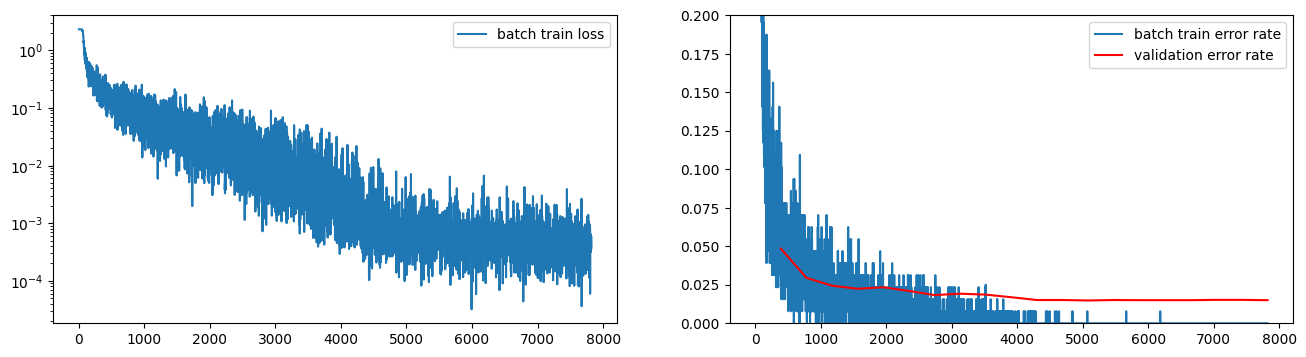

In [ ]:
t_start = time.time()
val_err = SGD(model, mnist_loaders,
    alpha=alpha, epsilon=epsilon, lr_schedule=lr_schedule, decay=decay,
    max_num_epochs=max_num_epochs, device=device)
##
best_hypers = check_if_best(val_err, best_val_err, alpha, epsilon, decay, max_num_epochs,
                            lr_schedule, hidden_neurons, gain)


In [ ]:
test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))
##

-------------------------------------------
Test error rate: 1.670%, training took 18s.
-------------------------------------------


## Conv2d and Maxpool

In [30]:
model = Model(nn.Unflatten(-1, (1, 28, 28)),
              nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(64*7*7, 64*7*7),
              nn.ReLU(),
              nn.Linear(64*7*7, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 23 | valid err rate:  0.84% | doing  23 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 15)



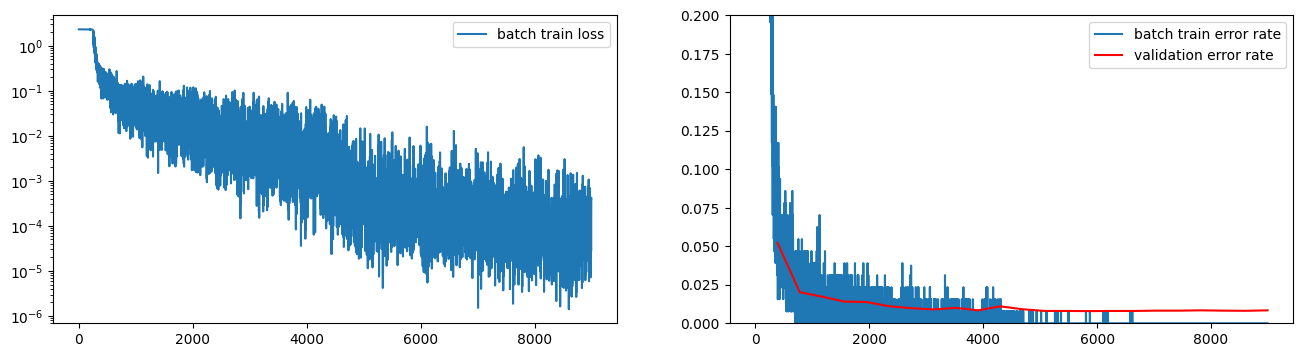

In [31]:
val_err = SGD(model, mnist_loaders,
    alpha=alpha, epsilon=epsilon, lr_schedule=lr_schedule, decay=decay,
    max_num_epochs=max_num_epochs, device=device)

In [32]:
test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {0:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))
##

------------------------------------------
Test error rate: 0.760%, training took 0s.
------------------------------------------


## Droput

In [26]:
a = torch.randn(3,3)

In [28]:
a.to(device)

tensor([[ 1.8395,  1.2388, -1.5590],
        [ 1.8026,  1.9889,  0.6779],
        [-0.3974, -0.4792, -0.2910]], device='cuda:0')

In [39]:
b = torch.rand(a.shape) > 0.2

In [35]:
class Dropout(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(Dropout, self).__init__()
        self.dropout_prob = dropout_prob

    def forward(self, x):
        if not self.training:
            return x
        mask = torch.rand(x.shape) > self.dropout_prob
        mask = mask.float().to(x.device)
        x = x * mask / (1 - self.dropout_prob)
        return x

In [36]:
model = Model(nn.Linear(28 * 28, hidden_neurons),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              Dropout(0.1),
              nn.ReLU(),
              nn.Linear(hidden_neurons, hidden_neurons),
              Dropout(0.1),
              nn.ReLU(),
              nn.Linear(hidden_neurons, 10))
model.init_params_xavier(gain=gain)

----------------------------------------------------------
After epoch 19 | valid err rate:  1.79% | doing  19 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 12)

------------------------------------------
Test error rate: 1.790%, training took 0s.
------------------------------------------


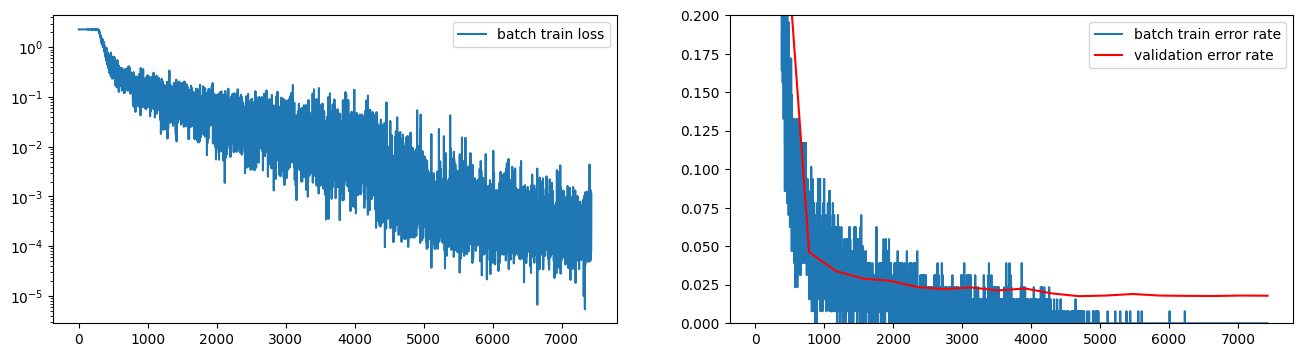

In [37]:
val_err = SGD(model, mnist_loaders,
    alpha=alpha, epsilon=epsilon, lr_schedule=lr_schedule, decay=decay,
    max_num_epochs=max_num_epochs, device=device)
test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {0:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))
##

device(type='cuda')